In [1]:
import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
from sklearn import preprocessing
import math
import re
%matplotlib inline

In [17]:
%%time
mydata = pd.read_csv("NY property data.csv")
mydata = pd.DataFrame(mydata)

CPU times: user 5.16 s, sys: 818 ms, total: 5.98 s
Wall time: 5.35 s


# Data Cleaning and missing value filling

In [18]:
#data=mydata.set_index('RECORD')
data=mydata.drop(columns=['BBLE','LOT','EASEMENT','OWNER','EXT','EXLAND', 'EXTOT', 'EXCD1','EXMPTCL',\
                       'AVLAND2', 'AVTOT2', 'EXLAND2', 'EXTOT2','EXCD2', 'PERIOD', 'YEAR', 'VALTYPE'])

In [19]:
# We notice Stories and ZIP have missing values
data.count()

RECORD      1070994
B           1070994
BLOCK       1070994
BLDGCL      1070994
TAXCLASS    1070994
LTFRONT     1070994
LTDEPTH     1070994
STORIES     1014730
FULLVAL     1070994
AVLAND      1070994
AVTOT       1070994
STADDR      1070318
ZIP         1041104
BLDFRONT    1070994
BLDDEPTH    1070994
dtype: int64

In [20]:
data['FULLVAL']=data['FULLVAL'].replace(0,np.NaN)
data['AVLAND']=data['AVLAND'].replace(0,np.NaN)
data['AVTOT']=data['AVTOT'].replace(0,np.NaN)
data['LTDEPTH']=data['LTDEPTH'].replace(0,np.NaN)
data['LTFRONT']=data['LTFRONT'].replace(0,np.NaN)
data['BLDFRONT']=data['BLDFRONT'].replace(0,np.NaN)
data['BLDDEPTH']=data['BLDDEPTH'].replace(0,np.NaN)

# Fill Zip

In [21]:
%%time
data['ZIP']=data.groupby(['STADDR'])['ZIP'].apply(lambda x:x.fillna(x.median()))
data['ZIP']=data['ZIP'].fillna(method="ffill")

CPU times: user 3min 4s, sys: 5.32 s, total: 3min 9s
Wall time: 3min 10s


# Fill AVLAND

In [22]:
data['AVLAND']=data.groupby(['ZIP','TAXCLASS'])['AVLAND'].apply(lambda x:x.fillna(x.median()))
data['AVLAND']=data.groupby(['TAXCLASS'])['AVLAND'].apply(lambda x:x.fillna(x.median()))

# Fill AVTOT

In [23]:
data['AVTOT']=data.groupby(['ZIP','TAXCLASS'])['AVTOT'].apply(lambda x:x.fillna(x.median()))
data['AVTOT']=data.groupby(['TAXCLASS'])['AVTOT'].apply(lambda x:x.fillna(x.median()))

# Fill FULLVAL

In [24]:
data['FULLVAL']=data.groupby(['ZIP','TAXCLASS'])['FULLVAL'].apply(lambda x:x.fillna(x.median()))
data['FULLVAL']=data.groupby(['TAXCLASS'])['FULLVAL'].apply(lambda x:x.fillna(x.median()))

# Fill LTDEPTH,LTFRONT,BLDFRONT,BLDDEPTH

In [25]:
data['LTDEPTH']=data.groupby(['B','BLDGCL'])['LTDEPTH'].apply(lambda x:x.fillna(x.median()))
data['LTFRONT']=data.groupby(['B','BLDGCL'])['LTFRONT'].apply(lambda x:x.fillna(x.median()))
data['BLDFRONT']=data.groupby(['B','BLDGCL'])['BLDFRONT'].apply(lambda x:x.fillna(x.median()))
data['BLDDEPTH']=data.groupby(['B','BLDGCL'])['BLDDEPTH'].apply(lambda x:x.fillna(x.median()))

In [26]:
data['LTDEPTH']=data.groupby(['BLDGCL'])['LTDEPTH'].apply(lambda x:x.fillna(x.median()))
data['LTFRONT']=data.groupby(['BLDGCL'])['LTFRONT'].apply(lambda x:x.fillna(x.median()))
data['BLDFRONT']=data.groupby(['BLDGCL'])['BLDFRONT'].apply(lambda x:x.fillna(x.median()))
data['BLDDEPTH']=data.groupby(['BLDGCL'])['BLDDEPTH'].apply(lambda x:x.fillna(x.median()))

In [27]:
data['BLDFRONT']=data.groupby(['ZIP'])['BLDFRONT'].apply(lambda x:x.fillna(x.median()))
data['BLDDEPTH']=data.groupby(['ZIP'])['BLDDEPTH'].apply(lambda x:x.fillna(x.median()))

# Fill Stories

In [28]:
data['STORIES']=data.groupby(['ZIP','BLDGCL'])['STORIES'].apply(lambda x:x.fillna(x.median()))
data['STORIES']=data.groupby(['BLDGCL'])['STORIES'].apply(lambda x:x.fillna(x.median()))
data['STORIES']=data.groupby(['ZIP'])['STORIES'].apply(lambda x:x.fillna(x.median()))

# Variable Creation

In [29]:
data['lotarea']=data['LTDEPTH']*data['LTFRONT']
data['bldarea']=data['BLDFRONT']*data['BLDDEPTH']
data['bldvol']=data['bldarea']*data['STORIES']

In [38]:
new_data=data.drop(columns=['BLOCK', 'BLDGCL','LTFRONT', 'LTDEPTH',\
                            'STORIES','STADDR','BLDFRONT','BLDDEPTH'])

In [33]:
data.isna().sum()

RECORD        0
B             0
BLOCK         0
BLDGCL        0
TAXCLASS      0
LTFRONT       0
LTDEPTH       0
STORIES       0
FULLVAL       0
AVLAND        0
AVTOT         0
STADDR      676
ZIP           0
BLDFRONT      0
BLDDEPTH      0
lotarea       0
bldarea       0
bldvol        0
dtype: int64

## Scale according to lotarea,bldarea and bldvol

In [39]:
new_data['fv/la']=new_data['FULLVAL']/new_data['lotarea']
new_data['al/la']=new_data['AVLAND']/new_data['lotarea']
new_data['at/la']=new_data['AVTOT']/new_data['lotarea']
new_data['fv/ba']=new_data['FULLVAL']/new_data['bldarea']
new_data['al/ba']=new_data['AVLAND']/new_data['bldarea']
new_data['at/ba']=new_data['AVTOT']/new_data['bldarea']
new_data['fv/bv']=new_data['FULLVAL']/new_data['bldvol']
new_data['al/bv']=new_data['AVLAND']/new_data['bldvol']
new_data['at/bv']=new_data['AVTOT']/new_data['bldvol']

In [40]:
new_data=new_data.drop(columns=['FULLVAL','AVLAND','AVTOT','lotarea','bldarea','bldvol'])

In [41]:
new_data['zip5']=new_data['ZIP']
dic = []
for i in new_data['ZIP']:
    dic.append(str(i)[:3])
    
new_data['zip3'] = pd.Series(dic)

## Scale according to zip5,zip3,B,Taxclass and all

In [42]:
new_data['fv/la/zip5']=new_data.groupby(['zip5'])['fv/la'].apply(lambda x:x/x.mean())
new_data['al/la/zip5']=new_data.groupby(['zip5'])['al/la'].apply(lambda x:x/x.mean())
new_data['at/la/zip5']=new_data.groupby(['zip5'])['at/la'].apply(lambda x:x/x.mean())
new_data['fv/ba/zip5']=new_data.groupby(['zip5'])['fv/ba'].apply(lambda x:x/x.mean())
new_data['al/ba/zip5']=new_data.groupby(['zip5'])['al/ba'].apply(lambda x:x/x.mean())
new_data['at/ba/zip5']=new_data.groupby(['zip5'])['at/ba'].apply(lambda x:x/x.mean())
new_data['fv/bv/zip5']=new_data.groupby(['zip5'])['fv/bv'].apply(lambda x:x/x.mean())
new_data['al/bv/zip5']=new_data.groupby(['zip5'])['al/bv'].apply(lambda x:x/x.mean())
new_data['at/bv/zip5']=new_data.groupby(['zip5'])['at/la'].apply(lambda x:x/x.mean())

new_data['fv/la/zip3']=new_data.groupby(['zip3'])['fv/la'].apply(lambda x:x/x.mean())
new_data['al/la/zip3']=new_data.groupby(['zip3'])['al/la'].apply(lambda x:x/x.mean())
new_data['at/la/zip3']=new_data.groupby(['zip3'])['at/la'].apply(lambda x:x/x.mean())
new_data['fv/ba/zip3']=new_data.groupby(['zip3'])['fv/ba'].apply(lambda x:x/x.mean())
new_data['al/ba/zip3']=new_data.groupby(['zip3'])['al/ba'].apply(lambda x:x/x.mean())
new_data['at/ba/zip3']=new_data.groupby(['zip3'])['at/ba'].apply(lambda x:x/x.mean())
new_data['fv/bv/zip3']=new_data.groupby(['zip3'])['fv/bv'].apply(lambda x:x/x.mean())
new_data['al/bv/zip3']=new_data.groupby(['zip3'])['al/bv'].apply(lambda x:x/x.mean())
new_data['at/bv/zip3']=new_data.groupby(['zip3'])['at/la'].apply(lambda x:x/x.mean())

new_data['fv/la/B']=new_data.groupby(['B'])['fv/la'].apply(lambda x:x/x.mean())
new_data['al/la/B']=new_data.groupby(['B'])['al/la'].apply(lambda x:x/x.mean())
new_data['at/la/B']=new_data.groupby(['B'])['at/la'].apply(lambda x:x/x.mean())
new_data['fv/ba/B']=new_data.groupby(['B'])['fv/ba'].apply(lambda x:x/x.mean())
new_data['al/ba/B']=new_data.groupby(['B'])['al/ba'].apply(lambda x:x/x.mean())
new_data['at/ba/B']=new_data.groupby(['B'])['at/ba'].apply(lambda x:x/x.mean())
new_data['fv/bv/B']=new_data.groupby(['B'])['fv/bv'].apply(lambda x:x/x.mean())
new_data['al/bv/B']=new_data.groupby(['B'])['al/bv'].apply(lambda x:x/x.mean())
new_data['at/bv/B']=new_data.groupby(['B'])['at/la'].apply(lambda x:x/x.mean())

new_data['fv/la/TX']=new_data.groupby(['TAXCLASS'])['fv/la'].apply(lambda x:x/x.mean())
new_data['al/la/TX']=new_data.groupby(['TAXCLASS'])['al/la'].apply(lambda x:x/x.mean())
new_data['at/la/TX']=new_data.groupby(['TAXCLASS'])['at/la'].apply(lambda x:x/x.mean())
new_data['fv/ba/TX']=new_data.groupby(['TAXCLASS'])['fv/ba'].apply(lambda x:x/x.mean())
new_data['al/ba/TX']=new_data.groupby(['TAXCLASS'])['al/ba'].apply(lambda x:x/x.mean())
new_data['at/ba/TX']=new_data.groupby(['TAXCLASS'])['at/ba'].apply(lambda x:x/x.mean())
new_data['fv/bv/TX']=new_data.groupby(['TAXCLASS'])['fv/bv'].apply(lambda x:x/x.mean())
new_data['al/bv/TX']=new_data.groupby(['TAXCLASS'])['al/bv'].apply(lambda x:x/x.mean())
new_data['at/bv/TX']=new_data.groupby(['TAXCLASS'])['at/la'].apply(lambda x:x/x.mean())

new_data['fv/la/all']=new_data['fv/la']/new_data['fv/la'].mean()
new_data['al/la/all']=new_data['al/la']/new_data['al/la'].mean()
new_data['at/la/all']=new_data['at/la']/new_data['at/la'].mean()
new_data['fv/ba/all']=new_data['fv/ba']/new_data['fv/ba'].mean()
new_data['al/ba/all']=new_data['al/ba']/new_data['al/ba'].mean()
new_data['at/ba/all']=new_data['at/ba']/new_data['at/ba'].mean()
new_data['fv/bv/all']=new_data['fv/bv']/new_data['fv/bv'].mean()
new_data['al/bv/all']=new_data['al/bv']/new_data['al/bv'].mean()
new_data['at/bv/all']=new_data['at/bv']/new_data['at/bv'].mean()

In [43]:
new_data=new_data.drop(columns=['B','ZIP','TAXCLASS','RECORD','fv/la','al/la','at/la','fv/ba',\
                               'al/ba','at/ba','fv/bv','al/bv','at/bv','zip5','zip3'])

In [44]:
new_data.isna().sum()

fv/la/zip5    0
al/la/zip5    0
at/la/zip5    0
fv/ba/zip5    0
al/ba/zip5    0
at/ba/zip5    0
fv/bv/zip5    0
al/bv/zip5    0
at/bv/zip5    0
fv/la/zip3    0
al/la/zip3    0
at/la/zip3    0
fv/ba/zip3    0
al/ba/zip3    0
at/ba/zip3    0
fv/bv/zip3    0
al/bv/zip3    0
at/bv/zip3    0
fv/la/B       0
al/la/B       0
at/la/B       0
fv/ba/B       0
al/ba/B       0
at/ba/B       0
fv/bv/B       0
al/bv/B       0
at/bv/B       0
fv/la/TX      0
al/la/TX      0
at/la/TX      0
fv/ba/TX      0
al/ba/TX      0
at/ba/TX      0
fv/bv/TX      0
al/bv/TX      0
at/bv/TX      0
fv/la/all     0
al/la/all     0
at/la/all     0
fv/ba/all     0
al/ba/all     0
at/ba/all     0
fv/bv/all     0
al/bv/all     0
at/bv/all     0
dtype: int64

# Z-scaling

In [45]:
from sklearn.preprocessing import normalize
new_Data=normalize(new_data,axis=0)
new_Data=pd.DataFrame(new_Data)

In [93]:
new_Data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44
0,0.000023,0.000017,0.000016,0.000640,0.000248,0.000334,0.000432,0.000108,0.000016,0.000016,0.000010,0.000017,0.000357,0.000103,0.000199,0.000241,0.000064,0.000017,0.000016,0.000010,0.000018,0.000348,0.000102,0.000186,0.000242,0.000064,0.000018,0.000030,0.000023,0.000024,0.000164,0.000042,0.000159,0.000029,0.000009,0.000024,0.000037,0.000045,0.000079,0.000332,0.000168,0.000350,0.000188,0.000090,0.000198
1,0.040968,0.010866,0.027561,0.014363,0.002081,0.007498,0.011315,0.001063,0.027561,0.028265,0.006468,0.029343,0.008007,0.000867,0.004459,0.006319,0.000623,0.029343,0.028589,0.006714,0.030879,0.007825,0.000856,0.004184,0.006334,0.000627,0.030879,0.053158,0.015331,0.042769,0.003682,0.000349,0.003576,0.000753,0.000091,0.042769,0.064279,0.029810,0.138629,0.007455,0.001413,0.007866,0.004933,0.000878,0.005190
2,0.000149,0.000200,0.000101,0.000041,0.000030,0.000021,0.000032,0.000015,0.000101,0.000103,0.000119,0.000107,0.000023,0.000012,0.000013,0.000018,0.000009,0.000107,0.000104,0.000124,0.000113,0.000022,0.000012,0.000012,0.000018,0.000009,0.000113,0.000194,0.000282,0.000156,0.000010,0.000005,0.000010,0.000002,0.000001,0.000156,0.000234,0.000549,0.000506,0.000021,0.000020,0.000022,0.000014,0.000013,0.000015
3,0.000051,0.000072,0.000034,0.000130,0.000099,0.000068,0.000154,0.000076,0.000034,0.000035,0.000043,0.000037,0.000073,0.000041,0.000040,0.000086,0.000045,0.000037,0.000036,0.000044,0.000039,0.000071,0.000041,0.000038,0.000086,0.000045,0.000039,0.000066,0.000101,0.000053,0.000033,0.000017,0.000032,0.000010,0.000007,0.000053,0.000080,0.000196,0.000173,0.000068,0.000068,0.000071,0.000067,0.000063,0.000071
4,0.000382,0.000610,0.000257,0.008354,0.007285,0.004361,0.019743,0.011163,0.000257,0.000263,0.000363,0.000274,0.004657,0.003037,0.002593,0.011026,0.006550,0.000274,0.000266,0.000377,0.000288,0.004551,0.002997,0.002434,0.011052,0.006590,0.000288,0.000496,0.000860,0.000399,0.002142,0.001224,0.002080,0.001313,0.000959,0.000399,0.000599,0.001673,0.001292,0.004336,0.004948,0.004575,0.008607,0.009227,0.009056


In [46]:
new_Data=new_Data.rename(columns={0:'fv/la/zip5', 1:'al/la/zip5', 2:'at/la/zip5', 3:'fv/ba/zip5', 4:'al/ba/zip5',
       5:'at/ba/zip5', 6:'fv/bv/zip5', 7:'al/bv/zip5', 8:'at/bv/zip5', 9:'fv/la/zip3',
       10:'al/la/zip3', 11:'at/la/zip3', 12:'fv/ba/zip3', 13:'al/ba/zip3', 14:'at/ba/zip3',
       15:'fv/bv/zip3', 16:'al/bv/zip3', 17:'at/bv/zip3', 18:'fv/la/B', 19:'al/la/B',
       20:'at/la/B', 21:'fv/ba/B', 22:'al/ba/B', 23:'at/ba/B', 24:'fv/bv/B', 25:'al/bv/B',
       26:'at/bv/B', 27:'fv/la/TX', 28:'al/la/TX', 29:'at/la/TX', 30:'fv/ba/TX', 31:'al/ba/TX',
       32:'at/ba/TX', 33:'fv/bv/TX', 34:'al/bv/TX', 35:'at/bv/TX', 36:'fv/la/all',
       37:'al/la/all', 38:'at/la/all', 39:'fv/ba/all', 40:'al/ba/all', 41:'at/ba/all',
       42:'fv/bv/all', 43:'al/bv/all', 44:'at/bv/all'})

In [51]:
new_Data.head()

,fv/la/zip5,al/la/zip5,at/la/zip5,fv/ba/zip5,al/ba/zip5,at/ba/zip5,fv/bv/zip5,al/bv/zip5,at/bv/zip5,fv/la/zip3,...,at/bv/TX,fv/la/all,al/la/all,at/la/all,fv/ba/all,al/ba/all,at/ba/all,fv/bv/all,al/bv/all,at/bv/all
0,0.000023,0.000017,0.000016,0.000640,0.000248,0.000334,0.000432,0.000108,0.000016,0.000016,...,0.000024,0.000037,0.000045,0.000079,0.000332,0.000168,0.000350,0.000188,0.000090,0.000198
1,0.040968,0.010866,0.027561,0.014363,0.002081,0.007498,0.011315,0.001063,0.027561,0.028265,...,0.042769,0.064279,0.029810,0.138629,0.007455,0.001413,0.007866,0.004933,0.000878,0.005190
2,0.000149,0.000200,0.000101,0.000041,0.000030,0.000021,0.000032,0.000015,0.000101,0.000103,...,0.000156,0.000234,0.000549,0.000506,0.000021,0.000020,0.000022,0.000014,0.000013,0.000015
3,0.000051,0.000072,0.000034,0.000130,0.000099,0.000068,0.000154,0.000076,0.000034,0.000035,...,0.000053,0.000080,0.000196,0.000173,0.000068,0.000068,0.000071,0.000067,0.000063,0.000071
4,0.000382,0.000610,0.000257,0.008354,0.007285,0.004361,0.019743,0.011163,0.000257,0.000263,...,0.000399,0.000599,0.001673,0.001292,0.004336,0.004948,0.004575,0.008607,0.009227,0.009056


In [47]:
from sklearn.decomposition import PCA
pca = PCA(n_components=8)
pca.fit(new_Data)

PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [48]:
data_pca= pca.transform(new_Data)

In [49]:
data_pca=pd.DataFrame(data_pca)

In [99]:
data_pca.head()

,0,1,2,3,4,5,6,7
0,0.000577,-0.000839,-0.000137,-0.000278,0.000223,0.000187,0.000243,0.000269
1,0.095457,0.121195,0.030063,-0.013460,0.003378,0.011924,0.008217,0.029999
2,0.000102,0.000244,-0.000205,0.000110,-0.000066,-0.000133,-0.000006,0.000175
3,0.000030,-0.000308,-0.000183,0.000011,0.000019,-0.000093,-0.000038,0.000116
4,0.026752,-0.014471,0.002457,-0.006118,0.009947,0.003837,-0.012341,0.007899


In [50]:
pca_norm=normalize(data_pca,axis=0)
pca_norm=pd.DataFrame(pca_norm)

In [95]:
#pca_norm.to_csv('pca norm.csv')

In [101]:
pca_norm.isnull().sum()

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
dtype: int64

In [102]:
pca_norm_z1=np.power(pca_norm,2)
pca_norm_z1 = pd.DataFrame(pca_norm_z1)
pca_norm_z1['zscores1']=pca_norm_z1.sum(axis=1)
pca_norm_z1['zscores1']=np.sqrt(pca_norm_z1['zscores1'])

In [103]:
pca_norm_z1.head(50)

,0,1,2,3,4,5,6,7,zscores1
0,1.553065e-08,6.049230e-08,5.688607e-09,3.336239e-08,2.837988e-08,3.724061e-08,6.728718e-08,1.292953e-07,0.000614
1,4.247694e-04,1.263078e-03,2.721907e-04,7.805519e-05,6.512725e-06,1.521365e-04,7.692202e-05,1.609697e-03,0.062317
2,4.871018e-10,5.112643e-09,1.260207e-08,5.179243e-09,2.522413e-09,1.899411e-08,4.348395e-11,5.490235e-08,0.000316
3,4.119580e-11,8.183891e-09,1.013178e-08,5.152701e-11,2.146297e-10,9.286483e-09,1.639764e-09,2.420673e-08,0.000232
4,3.336077e-05,1.800774e-05,1.818741e-06,1.612821e-05,5.648163e-05,1.575513e-05,1.735244e-04,1.116176e-04,0.020657
5,1.995541e-06,1.086602e-06,5.830374e-08,8.649367e-07,3.311512e-06,7.086152e-07,1.080239e-05,7.294085e-06,0.005111
6,8.389626e-06,5.973490e-06,4.479706e-07,4.457314e-06,1.540040e-05,3.812547e-06,4.762988e-05,2.761290e-05,0.010664
7,7.237333e-08,3.693805e-09,9.781358e-09,4.208818e-09,4.082070e-08,3.721764e-10,9.204176e-09,3.214858e-07,0.000680
8,8.529272e-10,1.111816e-08,2.699782e-09,9.820219e-10,2.899919e-09,1.380504e-08,3.332964e-09,4.477584e-08,0.000284
9,6.255185e-09,4.064801e-08,7.248558e-10,6.784283e-10,2.560018e-09,1.079894e-08,8.001681e-09,9.312360e-08,0.000403


In [104]:
finaldata=mydata
finaldata['zscores1']=pca_norm_z1['zscores1']

In [105]:
finaldata.sort_values(by="zscores1",ascending=False).head(10)

,RECORD,BBLE,B,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,LTDEPTH,EXT,STORIES,FULLVAL,AVLAND,AVTOT,EXLAND,EXTOT,EXCD1,STADDR,ZIP,EXMPTCL,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE,zscores1
632815,632816,4018420001,4,1842,1,NaN,"864163 REALTY, LLC",D9,2,157,95,NaN,1.0,2.930000e+06,1.318500e+06,1.318500e+06,0.000000e+00,0.000000e+00,NaN,86-55 BROADWAY,11373.0,NaN,1,1,1.201200e+06,1.201200e+06,NaN,NaN,NaN,FINAL,2010/11,AC-TR,0.987609
565391,565392,3085900700,3,8590,700,NaN,U S GOVERNMENT OWNRD,V9,4,117,108,NaN,NaN,4.326304e+09,1.946837e+09,1.946837e+09,1.946837e+09,1.946837e+09,2231.0,FLATBUSH AVENUE,NaN,X1,0,0,8.484847e+08,8.484847e+08,8.484847e+08,8.484847e+08,NaN,FINAL,2010/11,AC-TR,0.956515
67128,67129,1011110001,1,1111,1,NaN,CULTURAL AFFAIRS,Q1,4,840,0,E,NaN,6.150000e+09,2.668500e+09,2.767500e+09,2.668500e+09,2.767500e+09,2231.0,1000 5 AVENUE,10028.0,X1,0,0,2.371005e+09,2.465055e+09,2.371005e+09,2.465055e+09,NaN,FINAL,2010/11,AC-TR,0.910636
1067359,1067360,5078530085,5,7853,85,NaN,NaN,B2,1,1,1,NaN,2.0,8.360000e+05,2.880000e+04,5.016000e+04,0.000000e+00,0.000000e+00,NaN,20 EMILY COURT,10307.0,NaN,36,45,NaN,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,0.780585
556608,556609,3083120001,3,8312,1,NaN,PARKS AND RECREATION,Q1,4,35,50,NaN,1.0,1.360000e+08,6.075000e+07,6.120000e+07,6.075000e+07,6.120000e+07,2231.0,9006 SEAVIEW AVENUE,11236.0,X1,88,62,5.859000e+07,5.904000e+07,5.859000e+07,5.904000e+07,NaN,FINAL,2010/11,AC-TR,0.597612
585117,585118,4004200001,4,420,1,NaN,NEW YORK CITY ECONOMI,O3,4,298,402,NaN,20.0,3.443400e+06,1.549530e+06,1.549530e+06,0.000000e+00,0.000000e+00,NaN,28-10 QUEENS PLAZA SOUTH,11101.0,X1,1,1,1.585494e+06,1.585494e+06,NaN,NaN,NaN,FINAL,2010/11,AC-TR,0.532709
585438,585439,4004590005,4,459,5,NaN,11-01 43RD AVENUE REA,H9,4,94,165,NaN,10.0,3.712000e+06,2.520000e+05,1.670400e+06,0.000000e+00,1.418400e+06,1986.0,11-01 43 AVENUE,11101.0,NaN,1,1,NaN,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,0.481892
750815,750816,4066610005E,4,6661,5,E,M FLAUM,V0,1B,1,1,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,VLEIGH PLACE,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,0.455896
85885,85886,1012540010,1,1254,10,NaN,PARKS AND RECREATION,Q1,4,4000,150,NaN,1.0,7.021400e+07,3.145500e+07,3.159630e+07,3.145500e+07,3.159630e+07,2231.0,JOE DIMAGGIO HIGHWAY,NaN,X1,8,8,2.813400e+07,2.826018e+07,2.813400e+07,2.826018e+07,NaN,FINAL,2010/11,AC-TR,0.429740
920627,920628,4155770029,4,15577,29,NaN,"PLUCHENIK, YAAKOV",A1,1,91,100,NaN,2.0,1.900000e+06,9.763000e+03,7.576300e+04,0.000000e+00,0.000000e+00,NaN,7-06 ELVIRA AVENUE,11691.0,NaN,1,1,NaN,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,0.428170


In [106]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_row', None)
import matplotlib.pyplot as plt
plt.rcdefaults()
from pylab import rcParams
import seaborn as sns
%matplotlib inline
import datetime

####### Deep learning libraries
import tensorflow as tf
import keras
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from ann_visualizer.visualize import ann_viz
# 
from sklearn.preprocessing import  StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import (confusion_matrix, classification_report, accuracy_score, roc_auc_score, auc,
                             precision_score, recall_score, roc_curve, precision_recall_curve,
                             precision_recall_fscore_support, f1_score,
                             precision_recall_fscore_support)
#
from IPython.display import display, Math, Latex

# Data Preprocessing 

In [107]:
RANDOM_SEED = 101
df=pca_norm
X_train, X_test = train_test_split(df, test_size=0.5, random_state = RANDOM_SEED)
X_train = X_train.values
X_test  = X_test.values
print('Training data size   :', X_train.shape)
print('Validation data size :', X_test.shape)

Training data size   : (535497, 8)
Validation data size : (535497, 8)


# Model

In [108]:
# No of Neurons in each Layer [9,6,3,2,3,6,9]
input_dim = X_train.shape[1]
encoding_dim = 6

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh",activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="tanh")(encoder)
encoder = Dense(int(2), activation="tanh")(encoder)
decoder = Dense(int(encoding_dim/ 2), activation='tanh')(encoder)
decoder = Dense(int(encoding_dim), activation='tanh')(decoder)
decoder = Dense(input_dim, activation='tanh')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 8)                 0         
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 54        
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 21        
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 8         
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 9         
_________________________________________________________________
dense_11 (Dense)             (None, 6)                 24        
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 56        
Total para

In [109]:
nb_epoch = 1
batch_size = 50
autoencoder.compile(optimizer='adam', loss='mse' )

t_ini = datetime.datetime.now()
history = autoencoder.fit(X_train, X_train,
                        epochs=nb_epoch,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_split=0.1,
                        verbose=0
                        )

t_fin = datetime.datetime.now()
print('Time to run the model: {} Sec.'.format((t_fin - t_ini).total_seconds()))



df_history = pd.DataFrame(history.history)
# validation_data=(X_test_scaled, X_test_scaled)

Time to run the model: 10.917727 Sec.


In [110]:
predictions = autoencoder.predict(X_test)

mse = np.mean(np.power(X_test - predictions, 2), axis=1)
df_error = pd.DataFrame({'reconstruction_error': mse})
df_error.describe()

,reconstruction_error
count,5.354970e+05
mean,9.211163e-07
std,2.244693e-04
min,3.192696e-09
25%,9.371848e-09
50%,1.196994e-08
75%,1.784680e-08
max,1.298395e-01


In [111]:
outliers = df_error.sort_values(by = "reconstruction_error").tail(10)

In [112]:
predictions1 = autoencoder.predict(df)
predictions1 = pd.DataFrame(predictions1)

In [113]:
pca_norm_z2=np.power(df.values-predictions1.values,2)
pca_norm_z2 = pd.DataFrame(pca_norm_z2)
pca_norm_z2['zscores2']=pca_norm_z2.sum(axis=1)
pca_norm_z2['zscores2']=np.sqrt(pca_norm_z2['zscores2'])

In [114]:
pca_norm_z2.head()

,0,1,2,3,4,5,6,7,zscores2
0,1.501362e-09,7.565894e-08,9.280510e-09,8.624386e-09,1.984864e-08,1.188439e-11,7.618348e-08,1.901203e-07,0.000617
1,3.798917e-04,1.371467e-03,2.570108e-04,5.789590e-05,3.562975e-06,1.213002e-04,6.577269e-05,1.630632e-03,0.062350
2,4.286818e-09,2.303678e-08,6.175304e-09,3.426172e-10,1.035775e-12,3.306217e-08,9.536221e-09,8.007934e-08,0.000396
3,1.024992e-09,8.213377e-08,5.530414e-09,6.983723e-10,3.039548e-09,2.587887e-08,2.637427e-09,4.352351e-08,0.000406
4,3.298405e-05,1.804653e-05,1.914896e-06,1.563474e-05,5.692399e-05,1.388265e-05,1.743264e-04,1.159283e-04,0.020728


In [118]:
finaldata["zscores2"]=pca_norm_z2["zscores2"]

,RECORD,BBLE,B,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,LTDEPTH,EXT,STORIES,FULLVAL,AVLAND,AVTOT,EXLAND,EXTOT,EXCD1,STADDR,ZIP,EXMPTCL,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE,zscores1,zscore2,zscores2
0,1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500,1046,NaN,NaN,21400000.0,4225500.0,9630000.0,4225500.0,9630000.0,4600.0,1 LIBERTY ISLAND,10004.0,X3,0,0,3775500.0,8613000.0,3775500.0,8613000.0,NaN,FINAL,2010/11,AC-TR,0.000614,0.000617,0.000617
1,2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27,0,NaN,NaN,193800000.0,14310000.0,87210000.0,14310000.0,87210000.0,4600.0,1 ELLIS ISLAND,10004.0,X3,0,0,11111400.0,80690400.0,11111400.0,80690400.0,NaN,FINAL,2010/11,AC-TR,0.062317,0.062350,0.062350
2,3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709,564,E,3.0,104686000.0,39008700.0,47108700.0,39008700.0,47108700.0,2191.0,MARGINAL STREET,10004.0,X1,709,564,32321790.0,40179510.0,32321790.0,40179510.0,NaN,FINAL,2010/11,AC-TR,0.000316,0.000396,0.000396
3,4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793,551,NaN,2.0,39200000.0,15255000.0,17640000.0,15255000.0,17640000.0,2191.0,PIER 6,10004.0,X1,85,551,13644000.0,15750000.0,13644000.0,15750000.0,NaN,FINAL,2010/11,AC-TR,0.000232,0.000406,0.000406
4,5,1000030001,1,3,1,NaN,PARKS AND RECREATION,Q1,4,323,1260,NaN,1.0,272300000.0,121050000.0,122535000.0,121050000.0,122535000.0,2231.0,BATTERY PARK,10004.0,X1,89,57,106348680.0,107758350.0,106348680.0,107758350.0,NaN,FINAL,2010/11,AC-TR,0.020657,0.020728,0.020728


In [85]:
finaldata=pd.read_csv("finaldata.csv")

In [44]:
rank1=pd.DataFrame.rank(finaldata["zscores1"])
rank2=pd.DataFrame.rank(finaldata["zscore2"])

In [45]:
finaldata['rank1']=pd.Series(rank1)
finaldata['rank2']=pd.Series(rank2)

In [46]:
finaldata['finalrank']=0.5*finaldata['rank1']+0.5*finaldata['rank2']

In [63]:
finaldata=pd.concat([finaldata,new_Data],axis=1)

In [65]:
#finaldata.to_csv("finaldata.csv")

In [66]:
top10=finaldata.sort_values(by="finalrank",ascending=False).head(10)

In [56]:
topq1=finaldata[['ZIP','finalrank']]
topq1['ZIP']=data['ZIP']

In [60]:
topq1=topq1.sort_values(by="finalrank",ascending=False)

In [67]:
1070994/100

10709.94

In [68]:
topq1=topq1.head(10709)

In [69]:
topq1.to_csv('topq1.csv')

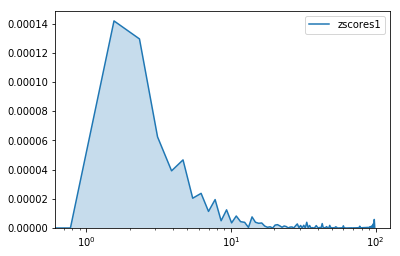

In [73]:
plot=sns.kdeplot(finaldata["zscores1"]*100,shade=True)
plot.set_xscale('log')

In [81]:
import seaborn as sns

Text(0.5, 0, 'Fraud Score 2')

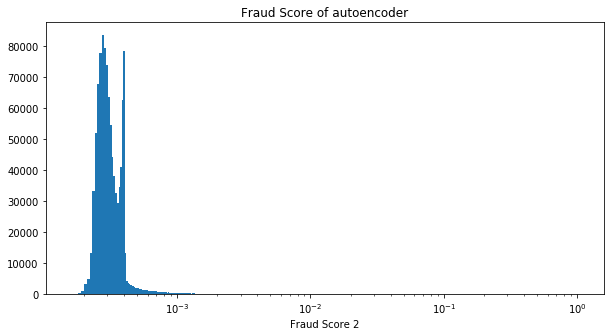

In [93]:
plt.figure(figsize=(10,5))
plt.hist(finaldata["zscore2"],bins=100000)
plt.gca().set_xscale("log")
plt.title("Fraud Score of autoencoder")
plt.xlabel("Fraud Score 2")